# Thuật toán ABC, qABC và GABC
Hàm mục tiêu: 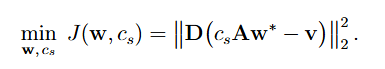

### CODE:

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass

# ============================================================
# 0) COMMON / PRINT
# ============================================================

@dataclass
class BeeResult:
    best_position: np.ndarray
    best_value: float
    history_best: np.ndarray
    n_iters: int
    n_evals: int

def print_like_slide(title, best_cost, w_opt, n_evals):
    print(f"\n--- Ket qua {title} ---")
    print(f"Gia tri tot nhat (minimized cost): {best_cost:.3f}")
    print("Vi tri w_opt tot nhat (w_0, w_1, ...):")
    for i, wi in enumerate(w_opt):
        print(f"w[{i}]: ({wi.real:.6f},{wi.imag:.6f})")
    print(f"So lan goi ham muc tieu (N_evals): {n_evals}")


# ============================================================
# 1) ABC / GABC / qABC (SAFE PROBABILITIES)
# ============================================================

def _project_bounds(x, low, high, wrap=False):
    x = np.asarray(x, dtype=float)
    if wrap:
        return np.mod(x - low, (high - low)) + low
    return np.clip(x, low, high)

def _fitness_from_cost(cost: float) -> float:
    # luôn >=0, tránh p âm / nan / inf
    if not np.isfinite(cost):
        return 0.0
    if cost >= 0:
        return 1.0 / (1.0 + cost)
    return 1.0 + abs(cost)

def _probs_from_costs(costs: np.ndarray) -> np.ndarray:
    fit = np.array([_fitness_from_cost(c) for c in costs], dtype=float)
    fit[~np.isfinite(fit)] = 0.0
    fit = np.clip(fit, 0.0, None)
    s = fit.sum()
    if s <= 0:
        return np.full_like(fit, 1.0 / len(fit), dtype=float)
    return fit / s

def artificial_bee_colony(
    func, bounds, colony_size=40, max_cycles=300, limit=60,
    minimize=True, seed=42, wrap_bounds=False
) -> BeeResult:
    rng = np.random.default_rng(seed)
    dim = len(bounds)
    low = np.array([b[0] for b in bounds], dtype=float)
    high = np.array([b[1] for b in bounds], dtype=float)

    n_evals = 0
    def eval_fn(x):
        nonlocal n_evals
        n_evals += 1
        return float(func(x))

    X = rng.uniform(low, high, size=(colony_size, dim))
    f = np.array([eval_fn(x) for x in X], dtype=float)
    trial = np.zeros(colony_size, dtype=int)

    if not minimize:
        f = -f

    hist = []

    for _ in range(max_cycles):
        # Employed
        for i in range(colony_size):
            k = rng.integers(0, colony_size - 1)
            if k >= i: k += 1
            j = rng.integers(0, dim)
            phi = rng.uniform(-1.0, 1.0)

            V = X[i].copy()
            V[j] = X[i, j] + phi * (X[i, j] - X[k, j])
            V = _project_bounds(V, low, high, wrap=wrap_bounds)

            fv = eval_fn(V)
            if not minimize:
                fv = -fv

            if fv < f[i]:
                X[i], f[i] = V, fv
                trial[i] = 0
            else:
                trial[i] += 1

        # Onlooker
        probs = _probs_from_costs(f)
        for _ in range(colony_size):
            i = rng.choice(colony_size, p=probs)
            k = rng.integers(0, colony_size - 1)
            if k >= i: k += 1
            j = rng.integers(0, dim)
            phi = rng.uniform(-1.0, 1.0)

            V = X[i].copy()
            V[j] = X[i, j] + phi * (X[i, j] - X[k, j])
            V = _project_bounds(V, low, high, wrap=wrap_bounds)

            fv = eval_fn(V)
            if not minimize:
                fv = -fv

            if fv < f[i]:
                X[i], f[i] = V, fv
                trial[i] = 0
            else:
                trial[i] += 1

        # Scout
        for i in range(colony_size):
            if trial[i] > limit:
                X[i] = rng.uniform(low, high, size=(dim,))
                f[i] = eval_fn(X[i])
                if not minimize:
                    f[i] = -f[i]
                trial[i] = 0

        hist.append(float(np.min(f)))

    best_idx = int(np.argmin(f))
    best_pos = X[best_idx].copy()
    best_val = float(f[best_idx])
    if not minimize:
        best_val = -best_val

    return BeeResult(best_pos, best_val, np.array(hist), max_cycles, n_evals)

def generalized_bee_colony(
    func, bounds, colony_size=40, max_cycles=300, limit=60,
    minimize=True, seed=42, wrap_bounds=False, psi_max=1.0
) -> BeeResult:
    rng = np.random.default_rng(seed)
    dim = len(bounds)
    low = np.array([b[0] for b in bounds], dtype=float)
    high = np.array([b[1] for b in bounds], dtype=float)

    n_evals = 0
    def eval_fn(x):
        nonlocal n_evals
        n_evals += 1
        return float(func(x))

    X = rng.uniform(low, high, size=(colony_size, dim))
    f = np.array([eval_fn(x) for x in X], dtype=float)
    trial = np.zeros(colony_size, dtype=int)

    if not minimize:
        f = -f

    hist = []

    for _ in range(max_cycles):
        best_idx = int(np.argmin(f))
        x_best = X[best_idx].copy()

        # Employed (GABC)
        for i in range(colony_size):
            k = rng.integers(0, colony_size - 1)
            if k >= i: k += 1
            j = rng.integers(0, dim)
            phi = rng.uniform(-1.0, 1.0)
            psi = rng.uniform(0.0, psi_max)

            V = X[i].copy()
            V[j] = X[i, j] + phi*(X[i, j]-X[k, j]) + psi*(x_best[j]-X[i, j])
            V = _project_bounds(V, low, high, wrap=wrap_bounds)

            fv = eval_fn(V)
            if not minimize:
                fv = -fv

            if fv < f[i]:
                X[i], f[i] = V, fv
                trial[i] = 0
            else:
                trial[i] += 1

        # Onlooker
        probs = _probs_from_costs(f)
        best_idx = int(np.argmin(f))
        x_best = X[best_idx].copy()

        for _ in range(colony_size):
            i = rng.choice(colony_size, p=probs)
            k = rng.integers(0, colony_size - 1)
            if k >= i: k += 1
            j = rng.integers(0, dim)
            phi = rng.uniform(-1.0, 1.0)
            psi = rng.uniform(0.0, psi_max)

            V = X[i].copy()
            V[j] = X[i, j] + phi*(X[i, j]-X[k, j]) + psi*(x_best[j]-X[i, j])
            V = _project_bounds(V, low, high, wrap=wrap_bounds)

            fv = eval_fn(V)
            if not minimize:
                fv = -fv

            if fv < f[i]:
                X[i], f[i] = V, fv
                trial[i] = 0
            else:
                trial[i] += 1

        # Scout
        for i in range(colony_size):
            if trial[i] > limit:
                X[i] = rng.uniform(low, high, size=(dim,))
                f[i] = eval_fn(X[i])
                if not minimize:
                    f[i] = -f[i]
                trial[i] = 0

        hist.append(float(np.min(f)))

    best_idx = int(np.argmin(f))
    best_pos = X[best_idx].copy()
    best_val = float(f[best_idx])
    if not minimize:
        best_val = -best_val

    return BeeResult(best_pos, best_val, np.array(hist), max_cycles, n_evals)

def quantum_bee_colony(
    func, bounds, colony_size=40, max_cycles=300, limit=60,
    minimize=True, seed=42, wrap_bounds=False, r=1.0
) -> BeeResult:
    rng = np.random.default_rng(seed)
    dim = len(bounds)
    low = np.array([b[0] for b in bounds], dtype=float)
    high = np.array([b[1] for b in bounds], dtype=float)

    n_evals = 0
    def eval_fn(x):
        nonlocal n_evals
        n_evals += 1
        return float(func(x))

    X = rng.uniform(low, high, size=(colony_size, dim))
    f = np.array([eval_fn(x) for x in X], dtype=float)
    trial = np.zeros(colony_size, dtype=int)

    if not minimize:
        f = -f

    hist = []

    for _ in range(max_cycles):
        # Employed
        for i in range(colony_size):
            k = rng.integers(0, colony_size - 1)
            if k >= i: k += 1
            j = rng.integers(0, dim)
            phi = rng.uniform(-1.0, 1.0)

            V = X[i].copy()
            V[j] = X[i, j] + phi * (X[i, j] - X[k, j])
            V = _project_bounds(V, low, high, wrap=wrap_bounds)

            fv = eval_fn(V)
            if not minimize:
                fv = -fv

            if fv < f[i]:
                X[i], f[i] = V, fv
                trial[i] = 0
            else:
                trial[i] += 1

        # Onlooker (qABC)
        probs = _probs_from_costs(f)

        for _ in range(colony_size):
            i = rng.choice(colony_size, p=probs)

            diff = X - X[i]
            dist = np.linalg.norm(diff, axis=1)
            md_i = (dist.sum() - dist[i]) / (colony_size - 1 + 1e-12)

            thresh = r * md_i
            mask = dist <= thresh
            mask[i] = True

            neigh = np.where(mask)[0]
            best_local = int(neigh[np.argmin(f[neigh])])
            x_bestN = X[best_local].copy()

            k = rng.integers(0, colony_size - 1)
            if k >= i: k += 1
            j = rng.integers(0, dim)
            phi = rng.uniform(-1.0, 1.0)

            V = x_bestN.copy()
            V[j] = x_bestN[j] + phi * (x_bestN[j] - X[k, j])
            V = _project_bounds(V, low, high, wrap=wrap_bounds)

            fv = eval_fn(V)
            if not minimize:
                fv = -fv

            if fv < f[i]:
                X[i], f[i] = V, fv
                trial[i] = 0
            else:
                trial[i] += 1

        # Scout
        for i in range(colony_size):
            if trial[i] > limit:
                X[i] = rng.uniform(low, high, size=(dim,))
                f[i] = eval_fn(X[i])
                if not minimize:
                    f[i] = -f[i]
                trial[i] = 0

        hist.append(float(np.min(f)))

    best_idx = int(np.argmin(f))
    best_pos = X[best_idx].copy()
    best_val = float(f[best_idx])
    if not minimize:
        best_val = -best_val

    return BeeResult(best_pos, best_val, np.array(hist), max_cycles, n_evals)


# ============================================================
# 2) BEAMFORMING: ULA / PATTERN / OBJECTIVE (your version)
# ============================================================

def ula_steering(N, angles_rad, d=0.5, wavelength=1.0):
    n = np.arange(N)
    k = 2*np.pi / wavelength
    return np.exp(1j * k * d * n[:, None] * np.sin(angles_rad)[None, :])

def beampattern_db(w, A_NxK):
    af = np.conjugate(w) @ A_NxK
    mag = np.abs(af)
    mag = mag / (mag.max() + 1e-12)
    return 20*np.log10(mag + 1e-12)

def phi_to_w(phi):
    w = np.exp(1j*np.asarray(phi))
    return w / (np.linalg.norm(w) + 1e-12)

def make_objective_linear_sll(N, angles_deg, steer_deg=0.0, mainlobe_deg=10.0, sll_target_db=-18.0):
    angles_deg = np.asarray(angles_deg)
    angles_rad = np.deg2rad(angles_deg)
    A_NxK = ula_steering(N, angles_rad)

    main_mask = np.abs(angles_deg - steer_deg) <= mainlobe_deg
    side_mask = ~main_mask
    steer_idx = int(np.argmin(np.abs(angles_deg - steer_deg)))
    thr = 10**(sll_target_db / 20.0)  # amplitude threshold

    def obj(phi):
        w = phi_to_w(phi)
        af = np.conjugate(w) @ A_NxK
        mag = np.abs(af)
        peak = mag.max() + 1e-12
        mag = mag / peak

        side_excess = mag[side_mask] - thr
        side_excess = side_excess[side_excess > 0]
        side_pen = float(np.mean(side_excess * side_excess)) if side_excess.size else 0.0

        main_pen = float((1.0 - mag[steer_idx])**2)

        return side_pen + 0.1 * main_pen

    return obj, A_NxK


# ============================================================
# 3) AUTHOR METHOD (ZHANG 2019): Generalized LS + cs + ILS
# ============================================================
# Paper setup:
# - A is KxM array response matrix at K angles (each row a_k^T)
# - Solve: min_{w, cs} || D (cs A w - v) ||_2^2  s.t. ||w||=1
# - cs has closed form; wopt is generalized eigenvector (Rayleigh quotient),
#   simplifies to normalized LS: wopt ∝ R2^{-1} (DA)^H v
# - If only magnitude known v = Dv p_v, optimize p_v via ILS. 【...】


@dataclass
class AuthorResult:
    w: np.ndarray            # (N,) complex
    cs: complex
    pv: np.ndarray           # (K,) complex unit-modulus (phase vector)
    history_cost: np.ndarray
    n_evals: int

def _weighted_cs(A_KxN, w, v, d_weight):
    """
    cs = argmin_cs || D (cs A w - v) ||^2
    D = diag(d_weight), d_weight >=0 real
    """
    y = A_KxN @ w          # (K,)
    Dw2 = (d_weight**2)    # diag squared weight
    num = np.vdot(y, Dw2 * v)         # y^H (D^2 v)
    den = np.vdot(y, Dw2 * y) + 1e-12 # y^H (D^2 y)
    return num / den

def zhang_generalized_ls_closed_form(A_KxN, v, d_weight=None):
    """
    Closed-form based on Theorem 1 and (11)(12)(13) in paper.
    Returns w (||w||=1) and cs.
    """
    K, N = A_KxN.shape
    if d_weight is None:
        d_weight = np.ones(K, dtype=float)
    d_weight = np.asarray(d_weight, dtype=float)

    # Build DA implicitly: multiply rows of A by d_weight
    DA = (d_weight[:, None] * A_KxN)  # KxN
    # u = (DA)^H v
    u = DA.conj().T @ v               # Nx1
    # R2 = (DA)^H (DA)
    R2 = DA.conj().T @ DA             # NxN

    # w ∝ R2^{-1} u
    # (if ill-conditioned, regularize a bit)
    reg = 1e-9 * np.trace(R2).real / N
    w0 = np.linalg.solve(R2 + reg*np.eye(N), u)
    w = w0 / (np.linalg.norm(w0) + 1e-12)

    cs = _weighted_cs(A_KxN, w, v, d_weight)
    return w, cs

def zhang_ils_magnitude_only(
    A_KxN, dv_mag, d_weight=None,
    max_iters=50, seed=42
) -> AuthorResult:
    """
    ILS for magnitude-only case:
    v = diag(dv_mag) * pv, |pv_k|=1.
    Iterate:
      pv <- exp(j angle(cs A w))
      v  <- dv_mag * pv
      w  <- closed-form generalized LS
      cs <- closed-form
    This matches the paper's idea of using ILS when only magnitude Dv known. :contentReference[oaicite:4]{index=4}
    """
    rng = np.random.default_rng(seed)
    K, N = A_KxN.shape

    if d_weight is None:
        d_weight = np.ones(K, dtype=float)
    d_weight = np.asarray(d_weight, dtype=float)
    dv_mag = np.asarray(dv_mag, dtype=float)

    # init pv random unit phases
    pv = np.exp(1j * rng.uniform(0, 2*np.pi, size=K))
    v = dv_mag * pv

    hist = []
    n_evals = 0

    for _ in range(max_iters):
        # LS step
        w, cs = zhang_generalized_ls_closed_form(A_KxN, v, d_weight=d_weight)

        # evaluate cost
        y = cs * (A_KxN @ w)
        err = (y - v)
        cost = float(np.sum((d_weight**2) * (np.abs(err)**2)))
        hist.append(cost)
        n_evals += 1

        # phase update
        pv = np.exp(1j * np.angle(y + 1e-12))
        v = dv_mag * pv

    return AuthorResult(w=w, cs=cs, pv=pv, history_cost=np.array(hist), n_evals=n_evals)

def author_rayleigh_gd_like(
    A_KxN, v, d_weight=None, steps=50, mu=0.2, seed=0
):
    """
    "GD-like" projected ascent on Rayleigh quotient.
    Not explicitly in paper; included because it's equivalent to finding the generalized eigenvector in (9). :contentReference[oaicite:5]{index=5}
    """
    rng = np.random.default_rng(seed)
    K, N = A_KxN.shape
    if d_weight is None:
        d_weight = np.ones(K, dtype=float)
    d_weight = np.asarray(d_weight, dtype=float)

    DA = d_weight[:, None] * A_KxN
    u = DA.conj().T @ v
    R2 = DA.conj().T @ DA
    reg = 1e-9 * np.trace(R2).real / N
    R2 = R2 + reg*np.eye(N)

    # init w random
    w = rng.normal(size=N) + 1j*rng.normal(size=N)
    w = w / (np.linalg.norm(w) + 1e-12)

    hist = []
    for _ in range(steps):
        # Rayleigh quotient numerator matrix R1 = u u^H (rank-1)
        R1w = u * np.vdot(u, w)  # (u u^H) w

        den = np.vdot(w, R2 @ w).real + 1e-12
        # ascent direction ~ grad of (w^H R1 w)/(w^H R2 w)  (rough, practical)
        g = R1w/den - (np.vdot(w, R1w)/(den**2)) * (R2 @ w)

        w = w + mu * g
        w = w / (np.linalg.norm(w) + 1e-12)

        # track surrogate
        val = (np.vdot(w, R1w).real) / den
        hist.append(val)

    cs = _weighted_cs(A_KxN, w, v, d_weight)
    return w, cs, np.array(hist)




### TESTING:





--- Ket qua ABC ---
Gia tri tot nhat (minimized cost): 0.000
Vi tri w_opt tot nhat (w_0, w_1, ...):
w[0]: (0.158095,-0.193664)
w[1]: (0.237103,-0.079259)
w[2]: (0.040914,-0.246629)
w[3]: (0.137188,-0.208997)
w[4]: (0.112228,-0.223394)
w[5]: (0.093876,-0.231705)
w[6]: (0.120820,-0.218867)
w[7]: (0.098207,-0.229903)
w[8]: (0.083339,-0.235700)
w[9]: (0.063191,-0.241882)
w[10]: (0.002017,-0.249992)
w[11]: (-0.005246,-0.249945)
w[12]: (-0.030977,-0.248073)
w[13]: (-0.131705,-0.212494)
w[14]: (0.136923,-0.209170)
w[15]: (0.020053,-0.249194)
So lan goi ham muc tieu (N_evals): 24064

--- Ket qua GABC ---
Gia tri tot nhat (minimized cost): 0.000
Vi tri w_opt tot nhat (w_0, w_1, ...):
w[0]: (0.081723,-0.236266)
w[1]: (-0.000971,-0.249998)
w[2]: (0.247673,-0.034030)
w[3]: (0.151449,-0.198905)
w[4]: (0.156430,-0.195012)
w[5]: (0.157944,-0.193788)
w[6]: (0.141239,-0.206280)
w[7]: (0.134281,-0.210876)
w[8]: (0.180839,-0.172619)
w[9]: (0.117120,-0.220868)
w[10]: (0.128626,-0.214372)
w[11]: (0.056181

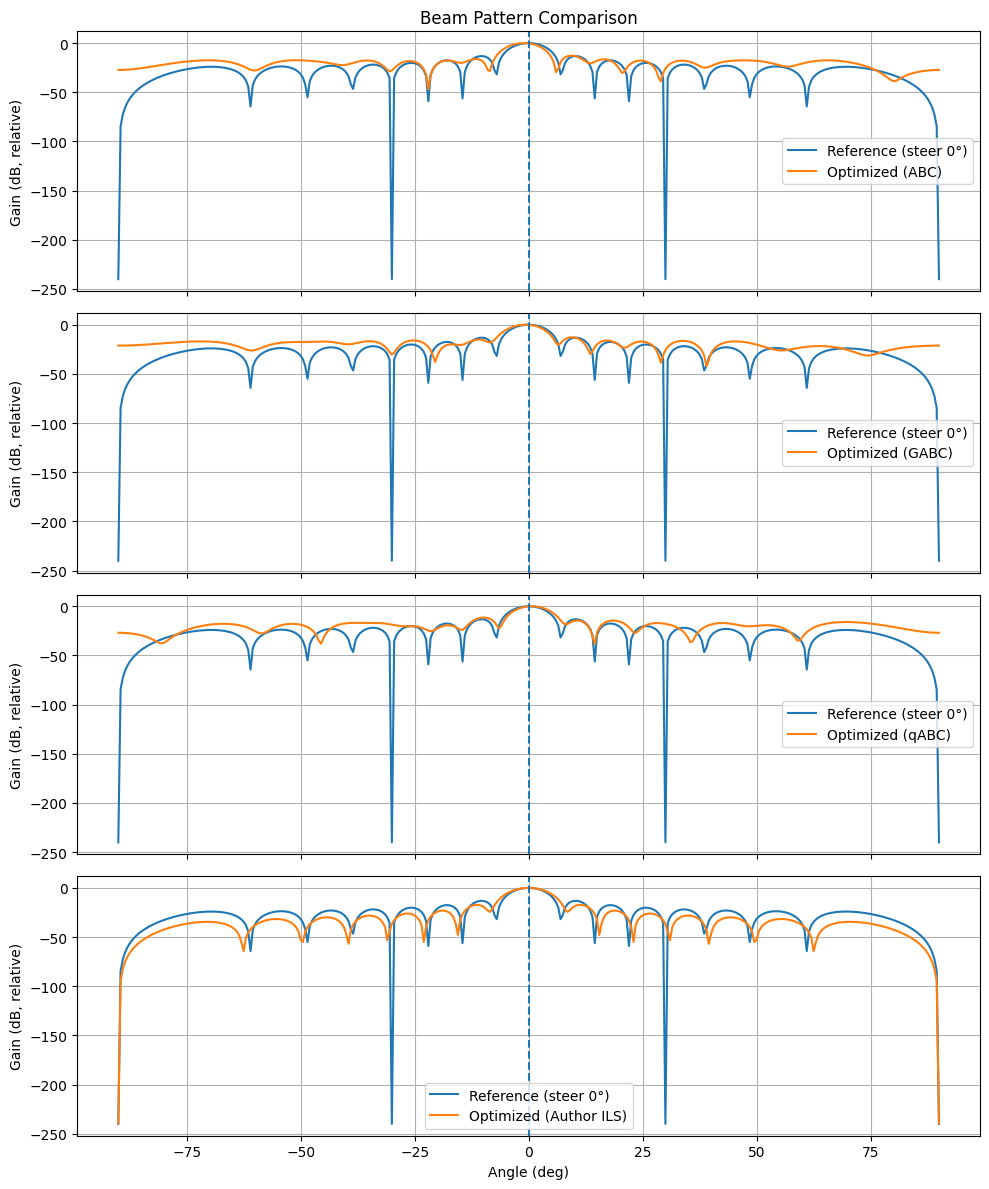

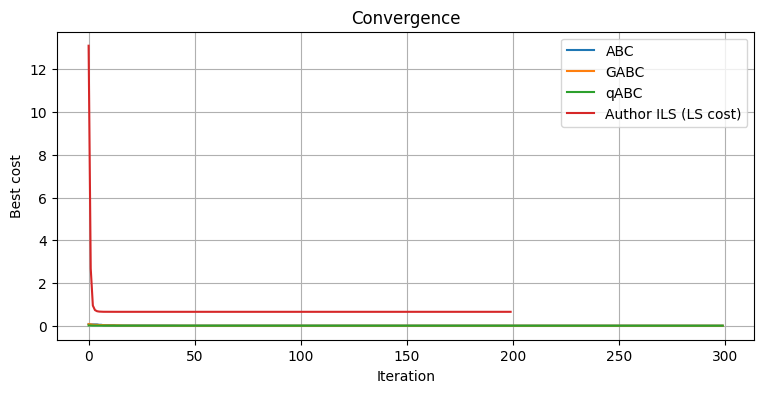

In [ ]:
# ============================================================
# 4) TESTING: ABC/GABC/qABC + AUTHOR (ILS)
# ============================================================

# ---------- RUN TEST ----------
N = 16
angles_deg = np.linspace(-90, 90, 361)
angles_rad = np.deg2rad(angles_deg)
steer_deg = 0.0
steer_rad = np.deg2rad(steer_deg)

# Your objective for ABC-family
obj, A_NxK = make_objective_linear_sll(
    N=N,
    angles_deg=angles_deg,
    steer_deg=steer_deg,
    mainlobe_deg=10.0,
    sll_target_db=-18.0
)
bounds_phi = [(0.0, 2*np.pi)] * N

# 1) ABC / GABC / qABC
res_abc = artificial_bee_colony(obj, bounds_phi, 40, 300, 60, True, 42, True)
res_gabc = generalized_bee_colony(obj, bounds_phi, 40, 300, 60, True, 42, True, psi_max=1.0)
res_qabc = quantum_bee_colony(obj, bounds_phi, 40, 300, 60, True, 42, True, r=1.0)

w_abc  = phi_to_w(res_abc.best_position)
w_gabc = phi_to_w(res_gabc.best_position)
w_qabc = phi_to_w(res_qabc.best_position)

# 2) Reference steering
a0 = ula_steering(N, np.array([steer_rad]))[:, 0]
w_ref = a0 / (np.linalg.norm(a0) + 1e-12)

# 3) AUTHOR ILS setup (Zhang): build A as KxN
A_KxN = A_NxK.T  # KxN

# Paper suggests Dv magnitude can be taken as mainlobe samples and zeros elsewhere. :contentReference[oaicite:6]{index=6}
# We'll create dv_mag: use reference beampattern magnitude, keep mainlobe, zero sidelobes
bp_ref_lin = np.abs((A_NxK.conj().T @ w_ref))  # (K,) but careful: A_NxK is N x K -> a(θ) column, so a^H w
# Here use row form: y = A_KxN @ w (same as conj(w)^T A_NxK)
y_ref = A_KxN @ w_ref
mag_ref = np.abs(y_ref)
mag_ref = mag_ref / (mag_ref.max() + 1e-12)

mainlobe_deg = 10.0
main_mask = np.abs(angles_deg - steer_deg) <= mainlobe_deg
dv_mag = np.zeros_like(mag_ref)
dv_mag[main_mask] = mag_ref[main_mask]  # keep mainlobe shape, sidelobes = 0

# D weight (paper has D as diagonal weighting; set identity for now)
d_weight = np.ones_like(dv_mag)

res_author_ils = zhang_ils_magnitude_only(
    A_KxN=A_KxN,
    dv_mag=dv_mag,
    d_weight=d_weight,
    max_iters=200,
    seed=42
)
w_author = res_author_ils.w

# 4) Print like slide
print_like_slide("ABC",  res_abc.best_value,  w_abc,  res_abc.n_evals)
print_like_slide("GABC", res_gabc.best_value, w_gabc, res_gabc.n_evals)
print_like_slide("qABC", res_qabc.best_value, w_qabc, res_qabc.n_evals)

# Author cost to print: use last ILS cost
author_cost = float(res_author_ils.history_cost[-1]) if res_author_ils.history_cost.size else 0.0
print_like_slide("AUTHOR_ILS", author_cost, w_author, res_author_ils.n_evals)

# 5) Beam patterns
bp_ref  = beampattern_db(w_ref,    A_NxK)
bp_abc  = beampattern_db(w_abc,    A_NxK)
bp_gabc = beampattern_db(w_gabc,   A_NxK)
bp_qabc = beampattern_db(w_qabc,   A_NxK)
bp_auth = beampattern_db(w_author, A_NxK)

fig, axes = plt.subplots(4, 1, figsize=(10, 12), sharex=True)

axes[0].plot(angles_deg, bp_ref, label="Reference (steer 0°)")
axes[0].plot(angles_deg, bp_abc, label="Optimized (ABC)")
axes[0].axvline(steer_deg, linestyle="--")
axes[0].set_title("Beam Pattern Comparison")
axes[0].set_ylabel("Gain (dB, relative)")
axes[0].grid(True)
axes[0].legend()

axes[1].plot(angles_deg, bp_ref, label="Reference (steer 0°)")
axes[1].plot(angles_deg, bp_gabc, label="Optimized (GABC)")
axes[1].axvline(steer_deg, linestyle="--")
axes[1].set_ylabel("Gain (dB, relative)")
axes[1].grid(True)
axes[1].legend()

axes[2].plot(angles_deg, bp_ref, label="Reference (steer 0°)")
axes[2].plot(angles_deg, bp_qabc, label="Optimized (qABC)")
axes[2].axvline(steer_deg, linestyle="--")
axes[2].set_ylabel("Gain (dB, relative)")
axes[2].grid(True)
axes[2].legend()

axes[3].plot(angles_deg, bp_ref, label="Reference (steer 0°)")
axes[3].plot(angles_deg, bp_auth, label="Optimized (Author ILS)")
axes[3].axvline(steer_deg, linestyle="--")
axes[3].set_xlabel("Angle (deg)")
axes[3].set_ylabel("Gain (dB, relative)")
axes[3].grid(True)
axes[3].legend()

plt.tight_layout()
plt.show()

# 6) Convergence
plt.figure(figsize=(9, 4))
plt.plot(res_abc.history_best,  label="ABC")
plt.plot(res_gabc.history_best, label="GABC")
plt.plot(res_qabc.history_best, label="qABC")
# Author ILS is also iterative but its metric is LS residual; still useful to plot
plt.plot(res_author_ils.history_cost, label="Author ILS (LS cost)")
plt.title("Convergence")
plt.xlabel("Iteration")
plt.ylabel("Best cost")
plt.grid(True)
plt.legend()
plt.show()
